In [1]:
## IMPORTS

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans
import seaborn as sns

<br> <br>
1. Data wrangling

In [2]:
## Data Readin

path = '/Users/ving2000/Downloads/CDS 403/Final_project/uci-restaurant-consumer-data/'

userprofile = pd.read_csv(os.path.join(path, 'userprofile.csv'))
usercuisine = pd.read_csv(os.path.join(path, 'usercuisine.csv'))

resgeo = pd.read_csv(os.path.join(path, 'geoplaces2.csv'), encoding = "ISO-8859-1")
rescuisine = pd.read_csv(os.path.join(path, 'chefmozcuisine.csv'))

ratings = pd.read_csv(os.path.join(path, 'rating_final.csv'))

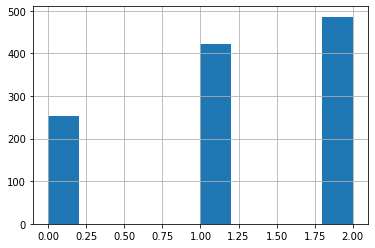

In [4]:
ratings['rating'].hist()

In [7]:
resgeo.columns

Index(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name', 'address',
       'city', 'state', 'country', 'fax', 'zip', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'url', 'Rambience', 'franchise',
       'area', 'other_services'],
      dtype='object')

In [5]:
for col in resgeo.columns[7:]:
    print(resgeo[col].value_counts(), end = '\n\n')

SLP                50
Morelos            19
?                  18
San Luis Potosi    14
tamaulipas          9
Tamaulipas          7
san luis potosi     4
slp                 2
S.L.P.              2
mexico              2
san luis potos      1
morelos             1
s.l.p.              1
Name: state, dtype: int64

Mexico    89
?         28
mexico    13
Name: country, dtype: int64

?    130
Name: fax, dtype: int64

?         74
78000     13
78269      3
78250      3
78421      2
78399      2
78270      2
78210      2
78310      2
62290      2
78280      1
62790      1
78290      1
78038      1
64000      1
78349      1
78390      1
62460      1
78214      1
62170      1
62250      1
78430      1
78000S     1
62000      1
78200      1
78740      1
74000      1
78433      1
78240      1
78395      1
79300      1
78220      1
87018      1
62320      1
78396      1
Name: zip, dtype: int64

No_Alcohol_Served    87
Wine-Beer            34
Full_Bar              9
Name: alcohol, dtype: int64

none

In [3]:
## Feature Selection

userprofile = userprofile.drop(['interest', 'religion', 'personality', 'color', 'activity', 'weight', 
                                'marital_status', 'birth_year', 'height', 'transport', 'hijos'], axis = 1)
for col in userprofile.columns[3:]:
    print(userprofile[col].value_counts(), end = '\n\n')

false    109
true      26
?          3
Name: smoker, dtype: int64

abstemious        51
casual drinker    47
social drinker    40
Name: drink_level, dtype: int64

no preference    53
formal           41
informal         35
?                 5
elegant           4
Name: dress_preference, dtype: int64

family      70
friends     46
solitary    16
?            6
Name: ambience, dtype: int64

medium    91
low       35
?          7
high       5
Name: budget, dtype: int64



In [4]:
userprofile[userprofile['budget'] == '?']

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,budget
23,U1024,22.154021,-100.976028,?,abstemious,?,?,?
48,U1049,22.150000,-100.983000,false,casual drinker,informal,solitary,?
82,U1083,22.133920,-101.028373,false,abstemious,?,?,?
84,U1085,22.196787,-100.936335,false,abstemious,no preference,solitary,?
121,U1122,22.169601,-100.991821,?,abstemious,?,?,?
129,U1130,23.733000,-99.133000,?,abstemious,?,?,?
131,U1132,22.150000,-100.983000,false,casual drinker,informal,solitary,?


In [5]:
userprofile.iloc[[23, 48, 82, 84, 121, 129, 131], :]

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,budget
23,U1024,22.154021,-100.976028,?,abstemious,?,?,?
48,U1049,22.150000,-100.983000,false,casual drinker,informal,solitary,?
82,U1083,22.133920,-101.028373,false,abstemious,?,?,?
84,U1085,22.196787,-100.936335,false,abstemious,no preference,solitary,?
121,U1122,22.169601,-100.991821,?,abstemious,?,?,?
129,U1130,23.733000,-99.133000,?,abstemious,?,?,?
131,U1132,22.150000,-100.983000,false,casual drinker,informal,solitary,?


In [6]:
## Fill in missing values

for col in userprofile.columns[3:]:
    entries = userprofile[col].unique().tolist()
    probs = userprofile[col].value_counts()
    
    if '?' in entries:
        entries.remove('?')
        missing = probs['?']
        probs = probs.drop('?', axis = 0)
        
        probs = list(probs/sum(probs))
    
        new_entries = np.random.choice(entries, missing, p = probs)
        ind = userprofile[userprofile[col] == '?'].index
        userprofile[col].update(pd.Series(dict(zip(ind, new_entries))))
    

In [7]:
for col in userprofile.columns[3:]:
    print(userprofile[col].value_counts(), end = '\n\n')

false    110
true      28
Name: smoker, dtype: int64

abstemious        51
casual drinker    47
social drinker    40
Name: drink_level, dtype: int64

no preference    55
formal           43
informal         36
elegant           4
Name: dress_preference, dtype: int64

family      74
friends     47
solitary    17
Name: ambience, dtype: int64

medium    97
low       36
high       5
Name: budget, dtype: int64



In [127]:
resgeo.columns

Index(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name', 'address',
       'city', 'state', 'country', 'fax', 'zip', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'url', 'Rambience', 'franchise',
       'area', 'other_services'],
      dtype='object')

In [9]:
## Feature Selection
restaurants = resgeo.drop(['the_geom_meter', 'address', 'city', 'state', 'country', 
                                                            'fax', 'zip', 'accessibility', 'url', 'franchise', 
                                                            'area', 'other_services'], axis = 1)
restaurants = restaurants[['placeID', 'latitude', 'longitude', 'smoking_area', 'alcohol', 
                         'dress_code', 'Rambience', 'price', 'name']]
restaurants.head()

,placeID,latitude,longitude,smoking_area,alcohol,dress_code,Rambience,price,name
0,134999,18.915421,-99.184871,none,No_Alcohol_Served,informal,familiar,medium,Kiku Cuernavaca
1,132825,22.147392,-100.983092,none,No_Alcohol_Served,informal,familiar,low,puesto de tacos
2,135106,22.149709,-100.976093,only at bar,Wine-Beer,informal,familiar,medium,El Rincón de San Francisco
3,132667,23.752697,-99.163359,none,No_Alcohol_Served,informal,familiar,low,little pizza Emilio Portes Gil
4,132613,23.752903,-99.165076,permitted,No_Alcohol_Served,informal,familiar,medium,carnitas_mata


In [10]:
for col in restaurants.columns[3:8]:
    print(restaurants[col].value_counts(), end = '\n\n')

none             70
not permitted    25
section          24
permitted         9
only at bar       2
Name: smoking_area, dtype: int64

No_Alcohol_Served    87
Wine-Beer            34
Full_Bar              9
Name: alcohol, dtype: int64

informal    118
casual       10
formal        2
Name: dress_code, dtype: int64

familiar    121
quiet         9
Name: Rambience, dtype: int64

medium    60
low       45
high      25
Name: price, dtype: int64



In [11]:
#pd.get_dummies(userprofile, columns=['smoker', 'drink_level'])
userprofile['smoker'].replace(['true', 'false'], [1, 0], inplace = True)
restaurants['smoking_area'].replace(['none', 'not permitted', 'section', 'permitted', 'only at bar'],
                                   [0, 0, 1, 1, 1], inplace = True)


userprofile['drink_level'].replace(['abstemious', 'casual drinker', 'social drinker'], 
                                   [0, 0.5, 1], inplace = True)
restaurants['alcohol'].replace(['No_Alcohol_Served', 'Wine-Beer', 'Full_Bar'],
                                   [0, 1, 1], inplace = True)


userprofile['dress_preference'].replace(['no preference', 'formal', 'informal', 'elegant'], 
                                        [0, 1, 0, 1], inplace = True)
restaurants['dress_code'].replace(['informal', 'casual', 'formal'],
                                   [0, 0, 1], inplace = True)


userprofile['ambience'].replace(['family', 'friends', 'solitary'], 
                                [1, 1, 0], inplace = True)
restaurants['Rambience'].replace(['familiar', 'quiet'],
                                   [1, 0], inplace = True)


userprofile['budget'].replace(['high', 'medium', 'low'], 
                                [1, 0.5, 0], inplace = True)
restaurants['price'].replace(['high', 'medium', 'low'], 
                                [1, 0.5, 0], inplace = True)


In [14]:
userprofile

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,budget
0,U1001,22.139997,-100.978803,0,0.0,0,1,0.5
1,U1002,22.150087,-100.983325,0,0.0,0,1,0.0
2,U1003,22.119847,-100.946527,0,1.0,1,1,0.0
3,U1004,18.867000,-99.183000,0,0.0,0,1,0.5
4,U1005,22.183477,-100.959891,0,0.0,0,1,0.5
...,...,...,...,...,...,...,...,...
133,U1134,22.149654,-100.998610,0,0.5,0,1,0.5
134,U1135,22.170396,-100.949936,0,0.5,0,1,0.0
135,U1136,22.149607,-100.997235,1,1.0,0,1,0.0
136,U1137,22.144803,-100.944623,0,1.0,1,1,0.0


In [15]:
#restaurants.to_csv('cleaned_restaurants.csv', index = False)
userprofile.to_csv('cleaned_userprofile.csv', index = False)

<br> <br>
2. Clustering

In [140]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(userprofile[['smoker', 'drink_level', 'dress_preference', 'ambience', 'budget']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Inertia')

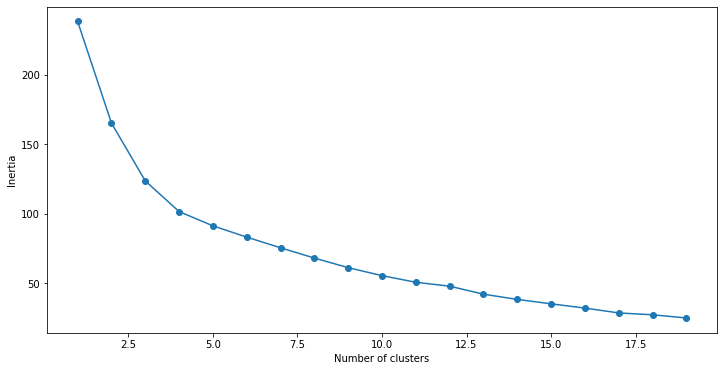

In [141]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(userprofile[['smoker', 'drink_level', 'dress_preference', 'ambience', 'transport', 'budget']])
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [142]:
kmeans = KMeans(n_jobs = -1, n_clusters = 7, init='k-means++')
kmeans.fit(userprofile[['smoker', 'drink_level', 'dress_preference', 'ambience', 'transport', 'budget']])
pred = kmeans.predict(userprofile[['smoker', 'drink_level', 'dress_preference', 'ambience', 'transport', 'budget']])

In [143]:
frame = userprofile.copy()
frame['user_cluster'] = pred
frame['user_cluster'].value_counts()

1    29
2    25
0    20
5    19
4    17
6    17
3    11
Name: user_cluster, dtype: int64

In [144]:
## User group 1

frame[frame['user_cluster'] == 2]

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,birth_year,budget,user_cluster
2,U1003,22.119847,-100.946527,0,2,2,1,0,1989,0.0,2
7,U1008,22.122989,-100.923811,0,2,2,0,0,1989,0.0,2
11,U1012,18.813348,-99.243697,0,1,2,1,0,1988,0.5,2
16,U1017,18.952615,-99.201616,0,1,2,1,0,1991,0.5,2
17,U1018,22.190949,-100.917902,1,1,2,1,0,1989,0.0,2
21,U1022,22.146708,-100.964355,0,1,2,1,1,1990,0.5,2
28,U1029,22.151796,-100.989075,1,1,2,1,0,1990,0.0,2
29,U1030,18.844818,-99.182758,0,1,2,1,0,1991,0.5,2
53,U1054,22.150683,-100.975342,0,2,2,1,0,1992,0.5,2
56,U1057,22.196624,-100.912170,1,1,2,1,0,1989,0.5,2


In [20]:
print('Statistics by user group')
frame.groupby(['user_cluster']).apply(np.mean)

Statistics by user group


,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,budget,user_cluster
user_cluster,,,,,,,,,
0,21.937213,-100.469890,0.000000,1.000000,0.000000,0.896552,0.000000,0.293103,0.0
1,21.624785,-100.388557,0.000000,1.000000,1.000000,0.894737,0.052632,0.368421,1.0
2,21.843008,-100.285365,0.000000,0.666667,0.000000,0.904762,1.000000,0.500000,2.0
3,21.972328,-99.860624,0.034483,0.000000,0.000000,0.793103,0.000000,0.431034,3.0
4,21.197518,-100.227576,1.000000,1.000000,0.250000,0.916667,1.000000,0.416667,4.0
5,21.845151,-100.256884,0.000000,0.000000,1.000000,0.866667,0.066667,0.466667,5.0
6,21.910420,-100.825536,1.000000,1.000000,0.307692,1.000000,0.000000,0.269231,6.0


In [21]:
temp = frame.merge(ratings, on = 'userID', how = 'left')
temp = temp[(temp['rating'] == 2) & (temp['food_rating'] == 2) 
           & (temp['service_rating'] == 2)][['user_cluster', 'placeID']].merge(restaurants, 
                                                                 on = 'placeID', how = 'left')
#resID = temp[temp['rating'] == 2]['placeID'].unique()

In [22]:
print('Restaurant stats by user group')
temp.drop(['placeID'], axis = 1).groupby(['user_cluster']).apply(np.mean)

Restaurant stats by user group


,user_cluster,latitude,longitude,smoking_area,alcohol,dress_code,Rambience,price
user_cluster,,,,,,,,
0,0.0,21.979288,-100.877869,0.263158,0.421053,0.000000,1.000000,0.535088
1,1.0,21.658727,-100.531814,0.325581,0.441860,0.093023,1.000000,0.511628
2,2.0,21.821889,-100.622274,0.152542,0.389831,0.050847,0.983051,0.559322
3,3.0,21.716172,-100.455273,0.405405,0.432432,0.000000,0.972973,0.500000
4,4.0,20.958322,-100.151894,0.266667,0.500000,0.066667,0.866667,0.466667
5,5.0,21.870275,-100.601035,0.282609,0.326087,0.043478,0.956522,0.554348
6,6.0,22.150491,-100.975078,0.190476,0.380952,0.000000,0.952381,0.595238


In [23]:
frame.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,budget,user_cluster
0,U1001,22.139997,-100.978803,0,0,0,1,0,0.5,3
1,U1002,22.150087,-100.983325,0,0,0,1,0,0.0,3
2,U1003,22.119847,-100.946527,0,1,1,1,0,0.0,1
3,U1004,18.867000,-99.183000,0,0,0,1,0,0.5,3
4,U1005,22.183477,-100.959891,0,0,0,1,0,0.5,3


<br> <br>
3. Build recommender

<br>
a. Brute force

In [23]:
def harvesine_dist(lat1, lon1, lat2, lon2):

    R = 6373.0 # approximate radius of earth in km

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [24]:
def RestaurantRecom1 (restaurants, user):
    """
    Gives recommendations based on user location and their means of transportation
    Similarity measure: sum of the absolute value of the difference between features
    """
    
    temp = restaurants.copy()
    temp['dist'] = harvesine_dist(user['latitude'], user['longitude'],
                                 temp['latitude'], temp['longitude'])
    ## Users who travel on foot can only come to restaurants that are 
    ## less 70 km from where they live
    if user['transport'] == 'on foot':
        temp = temp[temp['dist'] < 70]
     
    ## Calculate difference df
    diff_df = abs(temp[['smoking_area', 'alcohol',  'dress_code', 'Rambience','price']] - user[['smoker', 'drink_level', 'dress_preference', 
                                      'ambience', 'budget']].values)
    temp['diff'] = np.sum(diff_df, axis = 1)
    temp = temp[temp['diff'] <= 1.0]
    
    return temp

In [25]:
RestaurantRecom1(restaurants, userprofile.iloc[30])['placeID']

83     132717
89     132706
96     132715
123    132626
Name: placeID, dtype: int64

In [26]:
userprofile.iloc[30]

userID                U1031
latitude            23.7357
longitude          -99.1599
smoker                    0
drink_level               0
dress_preference          0
ambience                  0
transport           on foot
budget                  0.5
Name: 30, dtype: object

In [27]:
ratings[(ratings['userID'] == 'U1031') & (ratings['rating'] > 1)]

,userID,placeID,rating,food_rating,service_rating


In [14]:
restaurants.head(2)

,placeID,latitude,longitude,smoking_area,alcohol,dress_code,Rambience,price,name
0,134999,18.915421,-99.184871,0,0,0,1,0.5,Kiku Cuernavaca
1,132825,22.147392,-100.983092,0,0,0,1,0.0,puesto de tacos


In [26]:
onfoot = userprofile[userprofile['transport'] == 0]
carowners = userprofile[userprofile['transport'] == 1]
ronfoot = restaurants[restaurants['placeID'].isin(ratings[(ratings['userID'].isin(onfoot.userID)) &
                                                         (ratings['rating'] == 2)]['placeID'].tolist())]
ronfoot = restaurants[restaurants['placeID'].isin(ratings[(ratings['userID'].isin(carowners.userID)) &
                                                         (ratings['rating'] == 2)]['placeID'].tolist())]

In [25]:
ronfoot

,placeID,latitude,longitude,smoking_area,alcohol,dress_code,Rambience,price,name
0,134999,18.915421,-99.184871,0,0,0,1,0.5,Kiku Cuernavaca
1,132825,22.147392,-100.983092,0,0,0,1,0.0,puesto de tacos
2,135106,22.149709,-100.976093,1,1,0,1,0.5,El Rincón de San Francisco
3,132667,23.752697,-99.163359,0,0,0,1,0.0,little pizza Emilio Portes Gil
4,132613,23.752903,-99.165076,1,0,0,1,0.5,carnitas_mata
...,...,...,...,...,...,...,...,...,...
124,132583,18.922290,-99.234332,0,0,0,1,0.0,McDonalds Centro
125,132866,22.141220,-100.931311,0,0,0,1,0.5,Chaires
126,135072,22.149192,-101.002936,0,0,0,1,0.5,Sushi Itto
127,135109,18.921785,-99.235350,0,1,0,0,0.5,Paniroles


In [4]:
usercuisine

,userID,Rcuisine
0,U1001,American
1,U1002,Mexican
2,U1003,Mexican
3,U1004,Bakery
4,U1004,Breakfast-Brunch
...,...,...
325,U1135,Southern
326,U1135,Dessert-Ice_Cream
327,U1136,Mexican
328,U1137,Mexican


In [29]:
asian = ['Chinese', 'Japanese', 'Vietnamese', 'Burmese', 'Cambodian', 'Dim_Sum', 'Tibetan',
        'Filipino', 'Indian-Pakistani', 'Indonesian', 'Malaysian', 'Southeast_Asian', 'Thai',
        'Pacific_Rim', 'Afghan', 'Korean', 'Mongolian', 'Sushi', 'Thai']

no = ['Eclectic', 'Fusion', 'Indigenous', 'Cafeteria', 'Diner', 'Family', 'Fine_Dining',
     'International', 'Organic-Healthy', 'Regional', 'Seafood', 'Soup']

african = ['African', 'Ethiopian', 'North_African', 'Moroccan', 'Tunisian']

cafe = ['Doughnuts', 'Tea_House', 'Bagels', 'Bakery', 'Bar', 'Bar_Pub_Brewery'
        , 'Cafe-Coffee_Shop', 'Dessert-Ice_Cream', 'Juice']

fast_food = ['Breakfast-Brunch', 'Deli-Sandwiches', 'Burgers', 'Game', 'Hot_Dogs', 'Pizzeria']

latin = ['Chilean', 'Cuban', 'Jamaican', 'Peruvian', 'Tex-Mex', 'Tapas', 'Portuguese', 'Caribbean',
        'Latin_American', 'Mexican', 'Spanish', 'Brazilian']

european = ['American', 'Australian', 'Austrian', 'British', 'Basque',
            'Cajun-Creole', 'Canadian', 'French', 'Italian', 'Irish'
          'Hawaiian', 'Hungarian', 'Irish', 'Pacific_Northwest', 
           'Polynesian', 'Scandinavian', 'Swiss', 'Hawaiian',
          'Barbecue',  'California', 'Contemporary', 'Continental-European', 
            'Dutch-Belgian', 'German', 'Greek', 'Mediterranean', 'Polish',
           'Southern', 'Southwestern', 'Steaks', 'Hungarian']

middle_eastern = ['Israeli', 'Kosher', 'Lebanese', 'Middle_Eastern', 
                    'Armenian', 'Persian', 'Turkish', 'Romanian', 'Russian-Ukrainian', 'Eastern_European']


In [30]:
def Categorize (s):
    if s in asian:
        s = 'Asian'
    elif s in african:
        s = 'African'
    elif s in cafe:
        s = 'Cafe'
    elif s in fast_food:
        s = 'Fast_Food'
    elif s in latin:
        s = 'Latin'
    elif s in european:
        s = 'European/Western'
    elif s in middle_eastern:
        s = 'Middle Eastern/Eastern Europe'
    elif s in no:
        s = 'No preference'
    return s

In [31]:
usercuisine['category'] = usercuisine['Rcuisine'].apply(Categorize)

In [32]:
usercuisine[usercuisine['userID'] == 'U1004']

,userID,Rcuisine,category
3,U1004,Bakery,Cafe
4,U1004,Breakfast-Brunch,Fast_Food
5,U1004,Japanese,Asian
6,U1004,Contemporary,European/Western
7,U1004,Mexican,Latin
8,U1004,Bagels,Cafe
9,U1004,Cafe-Coffee_Shop,Cafe
10,U1004,Continental-European,European/Western
11,U1004,Cafeteria,No preference


In [33]:
rescuisine['category'] = rescuisine['Rcuisine'].apply(Categorize)

In [34]:
rescuisine

,placeID,Rcuisine,category
0,135110,Spanish,Latin
1,135109,Italian,European/Western
2,135107,Latin_American,Latin
3,135106,Mexican,Latin
4,135105,Fast_Food,Fast_Food
...,...,...,...
911,132005,Seafood,No preference
912,132004,Seafood,No preference
913,132003,International,No preference
914,132002,Seafood,No preference


In [21]:
rescuisine[rescuisine['placeID'] == 132109]

,placeID,Rcuisine,category
858,132109,Vegetarian,No preference
859,132109,Organic-Healthy,No preference


In [35]:
rescuisine.to_csv('restaurant_cuisine.csv', index = False)
usercuisine.to_csv('user_cuisine.csv', index = False)

https://en.wikipedia.org/wiki/Latin_American_cuisine

https://en.wikipedia.org/wiki/List_of_Asian_cuisines

https://en.wikipedia.org/wiki/Middle_Eastern_cuisine

https://en.wikipedia.org/wiki/European_cuisine

RESOURCES

https://github.com/egemenzeytinci/recommovie/blob/master/recommendation/recommendation.py

https://github.com/helger/content-recommender-movies/blob/master/Content-based%20Movie%20Recommender.ipynb

https://github.com/youonf/recommendation_system/blob/master/content_based_filtering/content_based_recommender_approach2_v2.ipynb

https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831 

https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17

https://medium.com/coinmonks/recommending-the-perfect-bottle-of-wine-118c28ba736e



Collaborative filtering:
Create a matrix whose columns are the restaurants and the rows are the users (sparse matrix)



In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
#from IPython.core import display
from sklearn.decomposition import NMF

from tqdm import tqdm

from sklearn.cluster import KMeans

In [55]:
path = '/Users/ving2000/Downloads/CDS 403/Final_project/uci-restaurant-consumer-data/'

users = pd.read_csv('cleaned_userprofile.csv').set_index('userID')
usercuisine = pd.read_csv('user_cuisine.csv')

restaurants = pd.read_csv('cleaned_restaurants.csv')
rescuisine = pd.read_csv('restaurant_cuisine.csv')

ratings = pd.read_csv(os.path.join(path, 'rating_final.csv'))

In [90]:
users = userprofile.drop(['latitude', 'longitude'], axis = 1)

In [109]:
#users.set_index('userID', inplace = True)
users

,smoker,drink_level,dress_preference,ambience,transport,hijos,birth_year,budget
userID,,,,,,,,
U1001,0,0,0,1,0,1,1989,0.5
U1002,0,0,0,1,0,1,1990,0.0
U1003,0,2,2,1,0,1,1989,0.0
U1004,0,0,0,1,0,1,1940,0.5
U1005,0,0,1,1,0,1,1992,0.5
...,...,...,...,...,...,...,...,...
U1134,0,1,1,1,0,1,1991,0.5
U1135,0,1,0,1,0,2,1988,0.0
U1136,1,2,1,1,1,1,1990,0.0


In [138]:
b = users.drop(['hijos', 'transport'], axis = 1)
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(users.drop(['birth_year', 'hijos', 'transport'], axis = 1))
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Inertia')

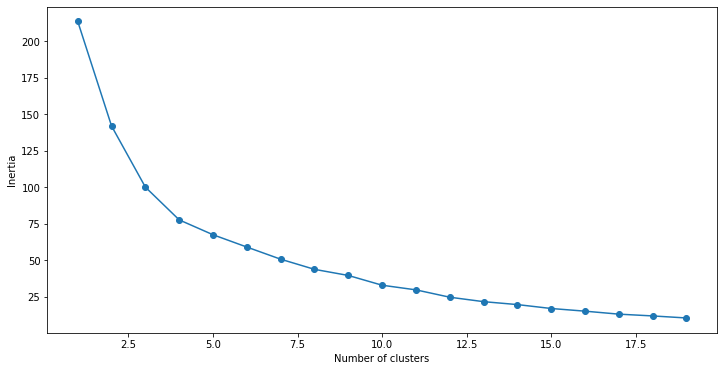

In [139]:
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
#plt.title('wiithout transport')

In [141]:
kmeans = KMeans(n_jobs = -1, n_clusters = 10, init='k-means++')
kmeans.fit(b)
pred = kmeans.predict(b)

frame = b.copy()
frame['user_cluster'] = pred
frame['user_cluster'].value_counts()

4    22
1    19
3    17
0    16
6    13
7    12
8    11
5    10
2     9
9     9
Name: user_cluster, dtype: int64

In [144]:
scaler = StandardScaler()
scaled_ = scaler.fit_transform(frame.drop('user_cluster', 1))
a = pd.DataFrame(scaled_, columns = b.columns, index = b.index)

In [145]:
a

,smoker,drink_level,dress_preference,ambience,budget
userID,,,,,
U1001,-0.493197,-1.138796,-1.371139,0.362143,0.417840
U1002,-0.493197,-1.138796,-1.371139,0.362143,-1.570501
U1003,-0.493197,1.336068,1.275255,0.362143,-1.570501
U1004,-0.493197,-1.138796,-1.371139,0.362143,0.417840
U1005,-0.493197,-1.138796,-0.047942,0.362143,0.417840
...,...,...,...,...,...
U1134,-0.493197,0.098636,-0.047942,0.362143,0.417840
U1135,-0.493197,0.098636,-1.371139,0.362143,-1.570501
U1136,2.027588,1.336068,-0.047942,0.362143,-1.570501


Best alpha using built-in LassoCV: 0.411344
Best score using built-in LassoCV: 0.096365
Lasso picked 1 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

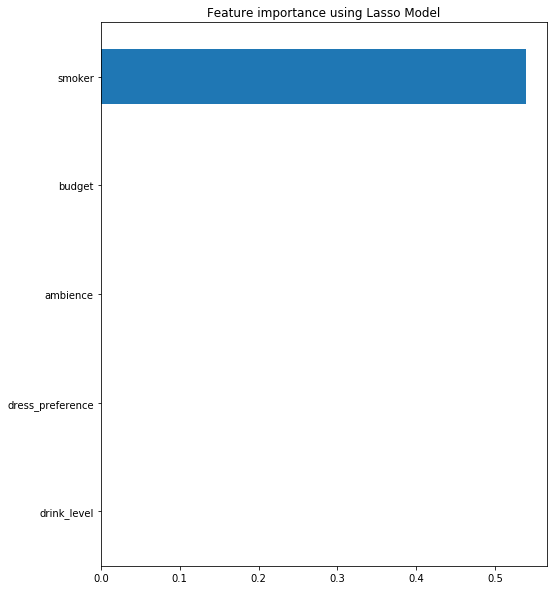

In [146]:
y = frame['user_cluster']        
X = a.copy()
#Target Variable
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [147]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d.  %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1.  dress_preference (0.414852)
2.  drink_level (0.391371)
3.  smoker (0.142042)
4.  budget (0.037757)
5.  ambience (0.013978)


In [128]:
indices

array([6, 1, 2, 7, 5, 4, 0, 3])